# Advanced Regression

#### problem statement
- us based company want to start in aus
- house sales buy at low and sell at high
- they got a csv file
- looking for properties to buy
- build a regression model using regularisation to predict the value
- wants to know which variables are significant
- how well they describe



- read data
- remove nulls
- change ordinal to numbers
- change categorical to dummies 
- check correlation
- feature selection
- train model 
- lasso and ridge
- create final model


In [1]:
# Import Statements, Importing required libraries
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score


In [2]:
#Reading the data from the CSV file
house_price = pd.read_csv('EDA_Gold_Silver_prices.csv')

In [3]:
# shape of the given dataframe
house_price.shape

(1460, 81)

In [4]:
#checking the percentages of null columns
round(house_price.isnull().sum()/len(house_price.index),2).sort_values(ascending=False).head(18)

PoolQC          1.00
MiscFeature     0.96
Alley           0.94
Fence           0.81
FireplaceQu     0.47
LotFrontage     0.18
GarageYrBlt     0.06
GarageFinish    0.06
GarageType      0.06
GarageQual      0.06
GarageCond      0.06
BsmtExposure    0.03
BsmtQual        0.03
BsmtCond        0.03
BsmtFinType2    0.03
BsmtFinType1    0.03
MasVnrType      0.01
MasVnrArea      0.01
dtype: float64

- taking the null values above 10% of data

In [5]:
round(house_price.isnull().sum()/len(house_price.index),2)[round(house_price.isnull().sum()/
                                                                 len(house_price.index),2).values>0.10]

LotFrontage    0.18
Alley          0.94
FireplaceQu    0.47
PoolQC         1.00
Fence          0.81
MiscFeature    0.96
dtype: float64

In [6]:
#dropping the null columns greater than 10 percent
house_price = house_price.drop(['LotFrontage','Alley','FireplaceQu','PoolQC','Fence','MiscFeature','MoSold'],axis='columns')

- Instead of the year numbers we convert the requied columns to age of the building

In [7]:
house_price['YearBuilt_Old'] = house_price.YearBuilt.max()-house_price.YearBuilt
house_price['YearRemodAdd_Old'] = house_price.YearRemodAdd.max()-house_price.YearRemodAdd
house_price['GarageYrBlt_Old'] = house_price.GarageYrBlt.max()-house_price.GarageYrBlt
house_price['YrSold_Old'] = house_price.YrSold.max()-house_price.YrSold
house_price[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuilt_Old','YearRemodAdd_Old',
             'GarageYrBlt_Old','YrSold_Old']].sample(10)
house_price = house_price.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','Id','Street','Utilities'],axis='columns')

- the null columns which are less than 10% nulls are replaced with appropriate not applicable and not available values

In [8]:
house_price.MasVnrType.fillna('None',inplace=True)
house_price.MasVnrArea.fillna(house_price.MasVnrArea.mean(),inplace=True)
house_price.BsmtQual.fillna('TA',inplace=True)
house_price.BsmtCond.fillna('TA',inplace=True)
house_price.BsmtExposure.fillna('No',inplace=True)
house_price.BsmtFinType1.fillna('Unf',inplace=True)
house_price.BsmtFinType2.fillna('Unf',inplace=True)
house_price.GarageType.fillna('Attchd',inplace=True)
house_price.GarageYrBlt_Old.fillna(-1,inplace=True)
house_price.GarageFinish.fillna('Unf',inplace=True)
house_price.GarageQual.fillna('TA',inplace=True)
house_price.GarageCond.fillna('TA',inplace=True)

In [9]:
house_price[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,Gtl,Gd,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,Reg
1,Gtl,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,RFn,TA,TA,TA,Reg
2,Gtl,Gd,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1
3,Gtl,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,Unf,TA,TA,TA,IR1
4,Gtl,Gd,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1


- handling the ordinal values giving the the ordered number so we can handle the data

In [10]:
house_price['LandSlope'] = house_price.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
house_price['ExterQual'] = house_price.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['BsmtQual'] = house_price.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['BsmtCond'] = house_price.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['BsmtExposure'] = house_price.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
house_price['BsmtFinType1'] = house_price.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price['BsmtFinType2'] = house_price.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price['HeatingQC'] = house_price.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['CentralAir'] = house_price.CentralAir.map({'N':0,'Y':1})
house_price['KitchenQual'] = house_price.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['GarageFinish'] = house_price.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
house_price['GarageQual'] = house_price.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['GarageCond'] = house_price.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['ExterCond'] = house_price.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['LotShape'] = house_price.LotShape.map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

In [11]:
house_price[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond',
             'ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0


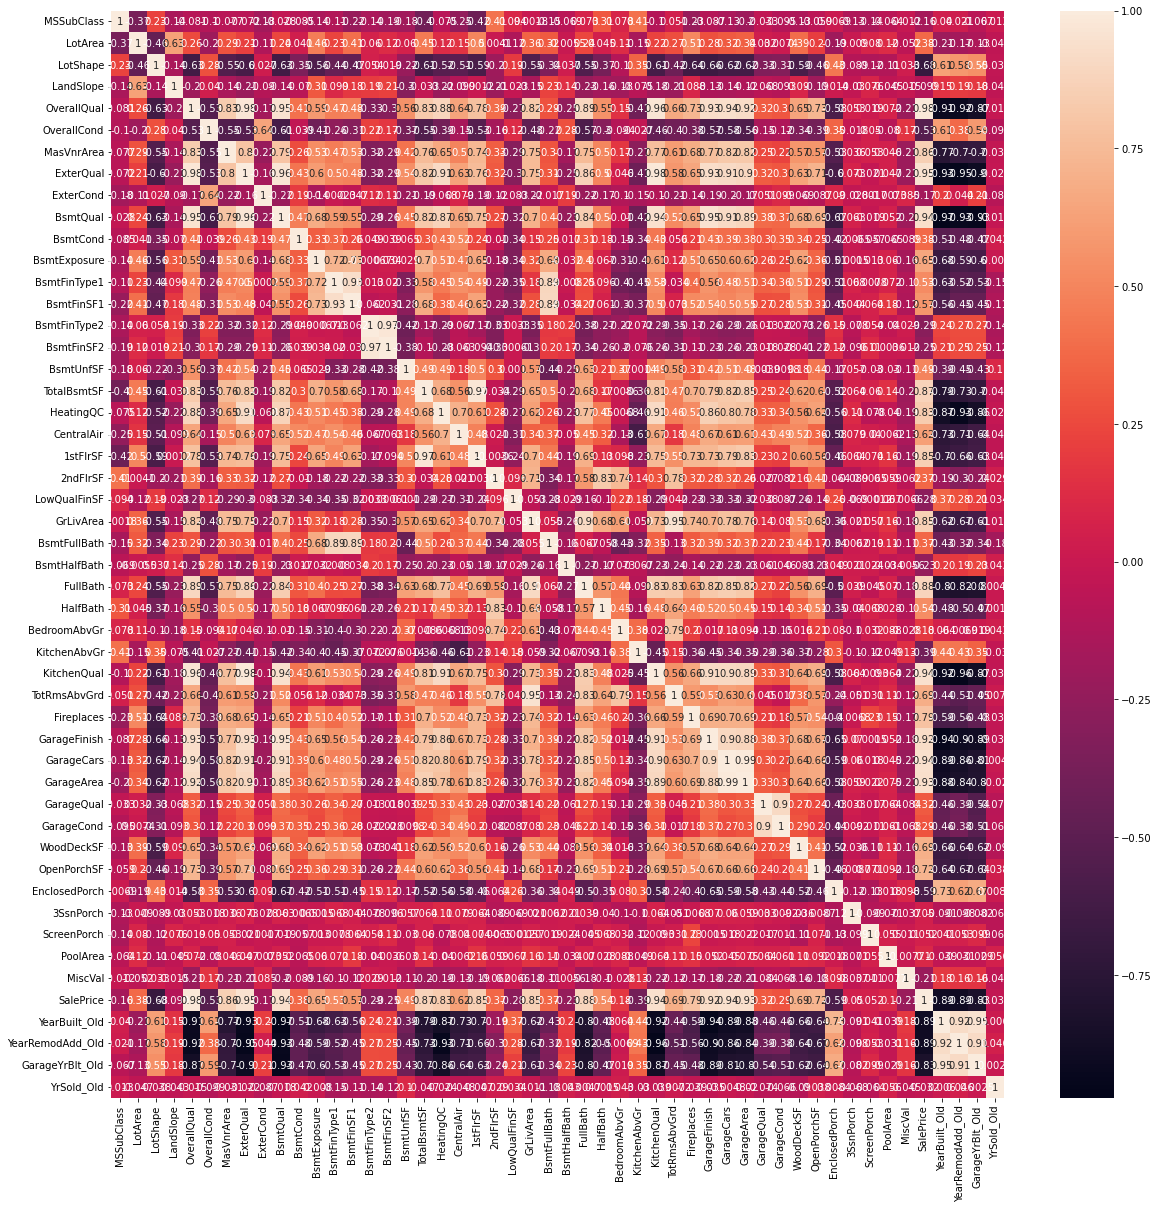

In [12]:
plt.figure(figsize=(20,20))
cor=house_price[list(house_price.dtypes[house_price.dtypes!='object'].index)].corr()
sns.heatmap(cor.corr(),annot=True)
plt.show()

- handling the categorical columns 

In [13]:
dummy_col = pd.get_dummies(house_price[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']],
                           drop_first=True)

house_price = pd.concat([house_price,dummy_col],axis='columns')

house_price = house_price.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis='columns')

In [14]:
house_price.shape

(1460, 195)

- removing the outliers from the data to make the genarlisation of data

In [15]:
num_col = list(house_price.dtypes[house_price.dtypes !='object'].index)
num_col = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF',
           'EnclosedPorch','3SsnPorch',
           'ScreenPorch' ,'PoolArea','MiscVal','SalePrice']
def drop_outliers(x):
    list = []
    for col in num_col:
        Q1 = x[col].quantile(.25)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x   

house_price = drop_outliers(house_price)

In [16]:
# sp;itting the data to train and test data
df_train,df_test = train_test_split(house_price,train_size=0.7,test_size=0.3,random_state=42)

In [17]:
#scaling the numerical data available
num_col = ['MSSubClass','LotArea','OverallQual','OverallCond',
           'MasVnrArea','BsmtFinSF1',
           'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
           'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
           'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',
           'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
           'ScreenPorch','PoolArea','MiscVal','SalePrice']

scaler = StandardScaler()
df_train[num_col] = scaler.fit_transform(df_train[num_col])
df_test[num_col] = scaler.transform(df_test[num_col])

C:\Users\Kaushik\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\Kaushik\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [18]:
y_train = df_train.pop('SalePrice')
X_train = df_train
y_test = df_test.pop('SalePrice')
X_test = df_test
X_train.shape

(1008, 194)

In [19]:
len(X_train.columns)

194

#### Linear Regression

In [20]:
# training the linear regression model
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,70)
rfe.fit(X_train,y_train)

C:\Users\Kaushik\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=70 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


RFE(estimator=LinearRegression(), n_features_to_select=70)

In [21]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']
rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

In [22]:
X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]

#### Lasso Regression

In [23]:
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8944296842100106
0.8505280684522615


In [85]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = df_train.columns
col.insert(0,'Constant')
list(zip(col,model_parameter))

[('MSSubClass', -1.217),
 ('LotArea', -0.107),
 ('LotShape', 0.226),
 ('LandSlope', 0.111),
 ('OverallQual', 0.164),
 ('OverallCond', 0.158),
 ('MasVnrArea', 0.043),
 ('ExterQual', -0.0),
 ('ExterCond', 0.063),
 ('BsmtQual', 0.0),
 ('BsmtCond', 0.017),
 ('BsmtExposure', -0.026),
 ('BsmtFinType1', 0.352),
 ('BsmtFinSF1', 0.151),
 ('BsmtFinType2', 0.102),
 ('BsmtFinSF2', -0.0),
 ('BsmtUnfSF', 0.109),
 ('TotalBsmtSF', 0.0),
 ('HeatingQC', -0.0),
 ('CentralAir', 0.2),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.212),
 ('LowQualFinSF', -0.127),
 ('GrLivArea', -0.14),
 ('BsmtFullBath', 0.0),
 ('BsmtHalfBath', -0.096),
 ('FullBath', 0.262),
 ('HalfBath', 0.456),
 ('BedroomAbvGr', -0.106),
 ('KitchenAbvGr', 0.252),
 ('KitchenQual', -0.14),
 ('TotRmsAbvGrd', -0.0),
 ('Fireplaces', -2.211),
 ('GarageFinish', 0.148),
 ('GarageCars', -0.0),
 ('GarageArea', -0.12),
 ('GarageQual', 0.13),
 ('GarageCond', 0.0),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', 0.0),
 ('EnclosedPorch', 0.0),
 ('3SsnPorch', -0.0),
 ('Scr

In [77]:
# finding the best values of alpha
folds = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001,0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [82]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.030318,0.004063,0.001404,0.002751,0.001,{'alpha': 0.001},0.851879,0.905966,0.822675,0.869088,...,0.900797,0.896642,0.893399,0.893565,0.893316,0.906569,0.894732,0.891500,0.895927,0.004424
1,0.006110,0.004472,0.002923,0.003641,0.010,{'alpha': 0.01},0.819150,0.866312,0.833688,0.829831,...,0.846919,0.844470,0.841953,0.841752,0.841093,0.876562,0.844218,0.838908,0.846622,0.010270
2,0.006074,0.003570,0.002620,0.003251,0.100,{'alpha': 0.1},0.741693,0.805251,0.769777,0.741077,...,0.780282,0.789278,0.783349,0.783012,0.776474,0.817421,0.783703,0.778584,0.786223,0.011038
3,0.004232,0.004053,0.001712,0.003188,1.000,{'alpha': 1.0},-0.006496,-0.021566,-0.018063,-0.001154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.006455,0.003937,0.001907,0.003094,5.000,{'alpha': 5.0},-0.006496,-0.021566,-0.018063,-0.001154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


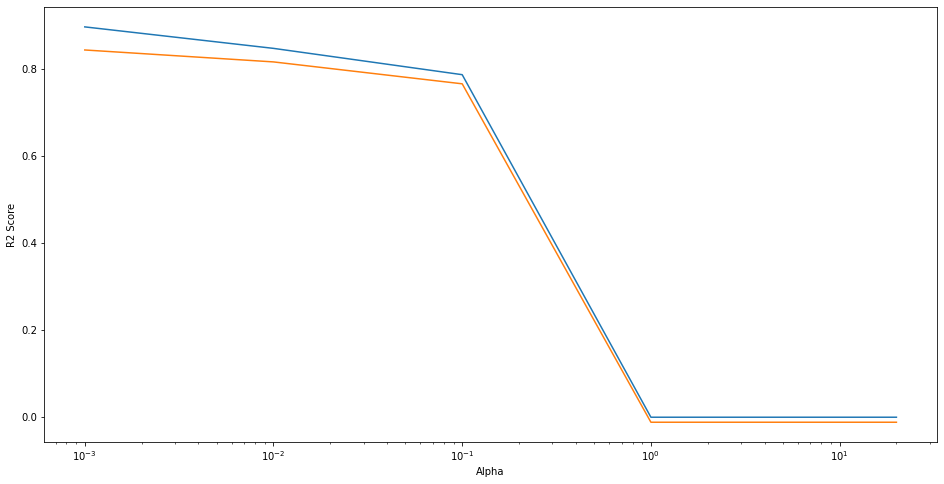

In [66]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [78]:
model_cv.best_params_

{'alpha': 0.001}

In [79]:
# training the lasso best alpha value
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8944296842100106
0.8505280684522615


#### Ridge Regression

In [45]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.9010535834888456
0.8379879504650175


In [46]:
# finding the best value of alpha for ridge regression
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,1.0, 5.0, 10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0,
                                   20.0]},
             return_train_score=True, scoring='r2', verbose=1)

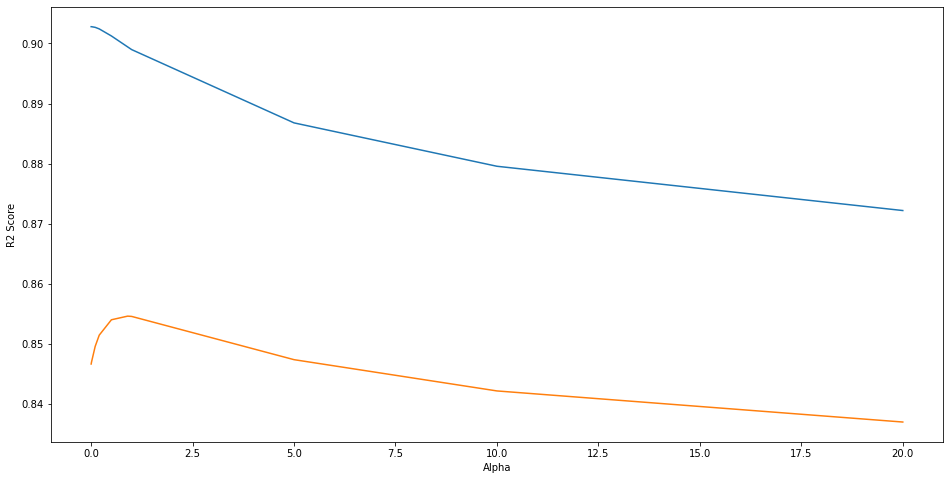

In [32]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')

plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
# plt.xscale('log')
plt.ylabel('R2 Score')
plt.show()

In [47]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 1.0}

In [56]:
# training the ridge regression with the best alpha value
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.8979681906081116
0.8469790977490682
